# Things to do still

- feature importances
    - RF -- talk to Beatriz about graph showing improtances
    - logistic regression for interpretability
- cost benefit analysis with confusion matrix
    - thresholds?
    - F1 scores?
- code that Aaron sent around
- visualizations after I have final model (talk to Jackie about hers?)
- Flask app
    - for presentation, take a video and put into GIF then put into pres. 
    - Use quicktime to do a screen recording; record whole thing, trim it, save to file, then embed in slide
    - then will just need to press play/spacebar on slides
- presentation!!
    - add more slides about why some models perform well vs others don't
        - dive into model documentation to better understand this so I can talk about it

In [1]:
import numpy as np
import pandas as pd

from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
file = open('cleaned_cc_default_data', 'rb')
model_data = pickle.load(file)

In [3]:
model_data.head()

,default_payment_next_month,age,education_level,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,sex,others,single
0,0,39,3.0,47174,47974,48630,50803,30789,15874,0,0,0,0,0,0,1800,2000,3000,2000,2000,2000,50000,1,0,1
1,0,29,3.0,48088,45980,44231,32489,26354,20221,0,0,0,0,0,0,2000,2010,3000,3000,3000,1000,110000,0,0,1
2,0,36,3.0,78630,68921,46512,40335,37165,22156,0,0,0,2,0,0,10076,4018,14,2051,2000,0,270000,1,0,1
3,0,45,3.0,58180,59134,61156,62377,63832,65099,0,0,0,0,0,0,2886,2908,2129,2354,2366,2291,130000,1,0,0
4,0,24,3.0,42058,35340,22110,19837,19855,20151,0,0,0,0,0,0,1367,1606,692,709,721,692,50000,1,0,1


In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2963 entries, 0 to 2964
Data columns (total 25 columns):
default_payment_next_month    2963 non-null int64
age                           2963 non-null int64
education_level               2963 non-null float64
bill_amt_1                    2963 non-null int64
bill_amt_2                    2963 non-null int64
bill_amt_3                    2963 non-null int64
bill_amt_4                    2963 non-null int64
bill_amt_5                    2963 non-null int64
bill_amt_6                    2963 non-null int64
pay_0                         2963 non-null int64
pay_2                         2963 non-null int64
pay_3                         2963 non-null int64
pay_4                         2963 non-null int64
pay_5                         2963 non-null int64
pay_6                         2963 non-null int64
pay_amt_1                     2963 non-null int64
pay_amt_2                     2963 non-null int64
pay_amt_3                     2963 non-nu

In [5]:
model_data.shape

(2963, 25)

# Splitting data into train/test & scaling

In [6]:
# Stratified train test split
x_raw = model_data.iloc[:, 1:]
y_raw = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_train, x_test = x_raw.loc[train_index,:], x_raw.loc[test_index,:]
    y_train, y_test = y_raw[train_index], y_raw[test_index]

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
x_train.shape

(2370, 24)

In [8]:
y_train.shape

(2370,)

In [9]:
x_test.shape

(593, 24)

In [10]:
y_test.shape

(593,)

In [11]:
# setting a scaler

scaler = StandardScaler()

In [12]:
type(x_train)

pandas.core.frame.DataFrame

In [13]:
x_train.columns

Index(['age', 'education_level', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
       'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_0', 'pay_2', 'pay_3',
       'pay_4', 'pay_5', 'pay_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'limit_balance', 'sex', 'others',
       'single'],
      dtype='object')

In [14]:
# splitting train data into features that will be scaled
# by dropping categorical features

X_for_scaling = x_train.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [15]:
# scale features that need to be scaled

X_train_scaled = scaler.fit_transform(X_for_scaling)

In [16]:
# convert those features to data frame

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [17]:
X_train_scaled.head()


,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
0,0.098135,-0.718157,-0.712797,-0.656081,-0.662030,-0.676581,-0.449010,-0.295507,-0.084792,-0.140569,-0.215248,0.570493,-0.248511,-0.019936
1,-0.885615,-0.045978,-0.046877,-0.134033,-0.063341,-0.001423,0.066774,-0.218995,-0.137506,-0.239268,-0.211688,-0.087358,-0.281494,-0.906082
2,1.300495,-0.028908,-0.032205,0.022519,0.102790,-0.656869,-0.702595,-0.295507,-0.122803,-0.198000,-0.328832,-0.294460,2.123603,-0.906082
3,-0.776309,3.168099,3.125140,3.332646,3.805802,3.916929,1.252276,-0.295281,0.117521,0.333052,0.173641,-0.292388,10.970793,0.946770
4,0.972579,0.179921,-0.213537,-0.207158,0.790165,0.447903,0.392444,-0.069978,-0.104321,4.464748,-0.153223,-0.111723,-0.149560,-0.100494


In [18]:
# merge scaled features with non-scaled features

# X_train = pd.merge(X_train_scaled, x_train.drop(columns=['age',  
#         'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
#         'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
#          'limit_balance']).reset_index(drop=True), left_index=True, right_index=True)

X_train = X_train_scaled.join(x_train.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [19]:
X_train.head()

,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,sex,others,single
0,0.098135,-0.718157,-0.712797,-0.656081,-0.662030,-0.676581,-0.449010,-0.295507,-0.084792,-0.140569,-0.215248,0.570493,-0.248511,-0.019936,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.885615,-0.045978,-0.046877,-0.134033,-0.063341,-0.001423,0.066774,-0.218995,-0.137506,-0.239268,-0.211688,-0.087358,-0.281494,-0.906082,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.300495,-0.028908,-0.032205,0.022519,0.102790,-0.656869,-0.702595,-0.295507,-0.122803,-0.198000,-0.328832,-0.294460,2.123603,-0.906082,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.776309,3.168099,3.125140,3.332646,3.805802,3.916929,1.252276,-0.295281,0.117521,0.333052,0.173641,-0.292388,10.970793,0.946770,3.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
4,0.972579,0.179921,-0.213537,-0.207158,0.790165,0.447903,0.392444,-0.069978,-0.104321,4.464748,-0.153223,-0.111723,-0.149560,-0.100494,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [20]:
X_train.shape

(2370, 24)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 24 columns):
age                2368 non-null float64
bill_amt_1         2368 non-null float64
bill_amt_2         2368 non-null float64
bill_amt_3         2368 non-null float64
bill_amt_4         2368 non-null float64
bill_amt_5         2368 non-null float64
bill_amt_6         2368 non-null float64
pay_amt_1          2368 non-null float64
pay_amt_2          2368 non-null float64
pay_amt_3          2368 non-null float64
pay_amt_4          2368 non-null float64
pay_amt_5          2368 non-null float64
pay_amt_6          2368 non-null float64
limit_balance      2368 non-null float64
education_level    2368 non-null float64
pay_0              2368 non-null float64
pay_2              2368 non-null float64
pay_3              2368 non-null float64
pay_4              2368 non-null float64
pay_5              2368 non-null float64
pay_6              2368 non-null float64
sex                2368 non-null

In [23]:
# get null value indices in X_train

inds = pd.isnull(X_train).any(1).nonzero()[0]
inds

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([1391, 1867])

In [24]:
# drop the above indices with null values from X_train and y_train

X_train.drop([1391, 1867], inplace = True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 24 columns):
age                2368 non-null float64
bill_amt_1         2368 non-null float64
bill_amt_2         2368 non-null float64
bill_amt_3         2368 non-null float64
bill_amt_4         2368 non-null float64
bill_amt_5         2368 non-null float64
bill_amt_6         2368 non-null float64
pay_amt_1          2368 non-null float64
pay_amt_2          2368 non-null float64
pay_amt_3          2368 non-null float64
pay_amt_4          2368 non-null float64
pay_amt_5          2368 non-null float64
pay_amt_6          2368 non-null float64
limit_balance      2368 non-null float64
education_level    2368 non-null float64
pay_0              2368 non-null float64
pay_2              2368 non-null float64
pay_3              2368 non-null float64
pay_4              2368 non-null float64
pay_5              2368 non-null float64
pay_6              2368 non-null float64
sex                2368 non-null

In [28]:
# converted y_train into a dataframe so I can deal with null values in x_train

y_train = pd.DataFrame(y_train, columns=['credit_card_default'])
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 1 columns):
credit_card_default    2370 non-null int64
dtypes: int64(1)
memory usage: 18.6 KB


In [29]:
# drop same rows with null values from y_train

y_train.drop([1391, 1867], inplace = True)
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 1 columns):
credit_card_default    2368 non-null int64
dtypes: int64(1)
memory usage: 37.0 KB


In [31]:
# split test data into features that will be scaled by dropping categorical features (same process as train data)

X_for_scaling2 = x_test.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [32]:
# scale test features

X_test_scaled = scaler.fit_transform(X_for_scaling2)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [33]:
# convert those features to dataframe

X_test_scaled = pd.DataFrame(X_test_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [34]:
X_test_scaled.head()

,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
0,-1.069387,-0.669816,-0.690259,-0.685146,-0.701047,-0.677536,-0.618999,-0.174529,-0.316118,-0.257875,-0.278114,-0.053508,0.005040,-0.677296
1,-1.181447,0.529878,0.555763,0.595420,0.707323,0.745784,0.783411,-0.160034,-0.201492,-0.114393,-0.118358,-0.108354,-0.126936,-0.521743
2,-0.621148,-0.726695,-0.724196,-0.683525,-0.715030,-0.689791,-0.671155,-0.329468,-0.312724,-0.322275,-0.349943,-0.218100,-0.213862,-0.366191
3,-1.405566,-0.140866,-0.111371,-0.280651,-0.251998,-0.190407,-0.177510,-0.243260,-0.316118,-0.271194,-0.324452,-0.234397,-0.196285,-0.910624
4,0.723570,2.604362,2.571945,2.404252,2.511060,2.601686,2.431268,0.173286,0.099860,0.150625,0.294966,0.047505,-0.015585,1.500438


In [35]:
# merge with categorical features that weren't scaled

# X_test = pd.merge(X_test_scaled, x_test.drop(columns=['age',  
#         'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
#         'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
#          'limit_balance']).reset_index(drop=True), left_index=True, right_index=True)

X_test = X_test_scaled.join(x_test.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [36]:
X_test.head()

,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,sex,others,single
0,-1.069387,-0.669816,-0.690259,-0.685146,-0.701047,-0.677536,-0.618999,-0.174529,-0.316118,-0.257875,-0.278114,-0.053508,0.005040,-0.677296,3.0,0,0,0,0,0,0,0,0,1
1,-1.181447,0.529878,0.555763,0.595420,0.707323,0.745784,0.783411,-0.160034,-0.201492,-0.114393,-0.118358,-0.108354,-0.126936,-0.521743,2.0,0,0,0,0,0,0,1,0,1
2,-0.621148,-0.726695,-0.724196,-0.683525,-0.715030,-0.689791,-0.671155,-0.329468,-0.312724,-0.322275,-0.349943,-0.218100,-0.213862,-0.366191,1.0,0,0,0,0,0,0,0,0,0
3,-1.405566,-0.140866,-0.111371,-0.280651,-0.251998,-0.190407,-0.177510,-0.243260,-0.316118,-0.271194,-0.324452,-0.234397,-0.196285,-0.910624,2.0,0,0,0,0,0,0,0,0,0
4,0.723570,2.604362,2.571945,2.404252,2.511060,2.601686,2.431268,0.173286,0.099860,0.150625,0.294966,0.047505,-0.015585,1.500438,1.0,0,0,0,0,0,0,1,0,0


In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 24 columns):
age                593 non-null float64
bill_amt_1         593 non-null float64
bill_amt_2         593 non-null float64
bill_amt_3         593 non-null float64
bill_amt_4         593 non-null float64
bill_amt_5         593 non-null float64
bill_amt_6         593 non-null float64
pay_amt_1          593 non-null float64
pay_amt_2          593 non-null float64
pay_amt_3          593 non-null float64
pay_amt_4          593 non-null float64
pay_amt_5          593 non-null float64
pay_amt_6          593 non-null float64
limit_balance      593 non-null float64
education_level    593 non-null float64
pay_0              593 non-null int64
pay_2              593 non-null int64
pay_3              593 non-null int64
pay_4              593 non-null int64
pay_5              593 non-null int64
pay_6              593 non-null int64
sex                593 non-null int64
others             593 non-nu

In [63]:
# pickle column names to use later in Flask app

column_names = list(X_train.columns)

with open('column_names.pkl', 'wb') as f:
    pickle.dump(column_names, f)

# Modeling Round I

- KNN
- Logistic Regression
- SVM
- Naive Bayes
- Random Forest
- XGBoost ?

In [41]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### KNN GridSearchCV

In [43]:
# Run CV with 5 folds (knn)

ks = range(1,301,50)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0897s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': range(1, 301, 50)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [44]:
# this is my best model based on above
# can run .predict(x_test)

knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

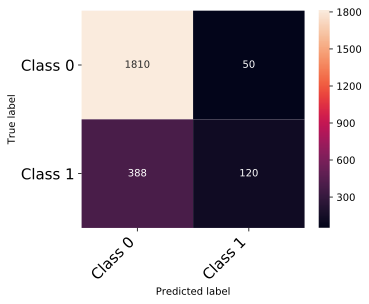

In [46]:
cm = print_confusion_matrix(confusion_matrix(y_train, knn_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Logistic Regression GridSearchCV

In [ ]:
## NOTES

# need to do np.exp(coefficients) to scale them back from log odds after you get coefficients
# also need to unscale (because originally scaled them)
# note: no need to scale categorical variables
# create a subset of dataframe; scale it; drop it back in
# for pay_# columns -- use label encoding, because you want to keep it valued as it is; do not scale either

In [47]:
# Run CV with 5 folds (logit)

penalty = ['l1', 'l2'] # look into doing elastic net here to see what combo of l1 and l2 is best
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1020s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1314s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1952s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [48]:
# best model for logistic regression (metric = C)

logistic_grid.best_estimator_

LogisticRegression(C=0.26560877829466867, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

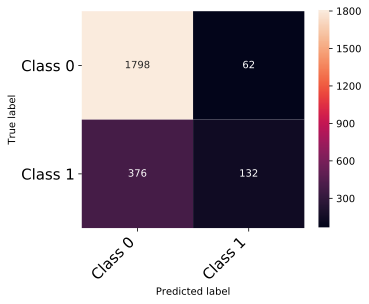

In [49]:
cm = print_confusion_matrix(confusion_matrix(y_train, logistic_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [84]:
from sklearn.feature_selection import RFE

rfe.support_

NameError: name 'rfe' is not defined

In [ ]:
# print coefficients
# then get coefficients
# those coefficients will tell me which features are most important
# purpose of this is interpretation of what really contributed to my model (presentation)

logistic2 = linear_model.LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) # ADD PARAMETERS FROM BEST ESTIMATE
logistic2.fit(x_norm_train, y_train)

In [ ]:
a = logistic2.coef_
# a_list = a.tolist()
# flat_list = [item for x in a_list for item in x]
# a_df = pd.DataFrame(flat_list)
# a_df

In [ ]:
b = x_cols
# b_df = pd.DataFrame(b)
# b_df

In [ ]:
# logistic_coef = pd.concat([b_df, a_df], ignore_index = True, axis = 1)
# logistic_coef

list(zip(a,b))

In [ ]:
# because ROC-AUC scores between logit and RF are so close, can just opt to use logit since it will get rid of features (becuase it chose l1)
# or if I decide to use RF, can then do EDA on features of low importance to inuit which features are important vs. not and why

### SVM GridSearchCV

In [50]:
# Run CV with 5 folds (SVM)

C = np.logspace(-3, 1, 25)
gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.46780e-03, 2.15443e-03, 3.16228e-03, 4.64159e-03,
       6.81292e-03, 1.00000e-02, 1.46780e-02, 2.15443e-02, 3.16228e-02,
       4.64159e-02, 6.81292e-02, 1.00000e-01, 1.46780e-01, 2.15443e-01,
       3.16228e-01, 4.64159e-01, 6.81292e-01, 1.00000e+00, 1.46780e..., 0.07499, 0.1    , 0.13335, 0.17783, 0.23714, 0.31623,
       0.4217 , 0.56234, 0.74989, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [51]:
svm_grid.best_estimator_

SVC(C=4.6415888336127775, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.042169650342858224,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

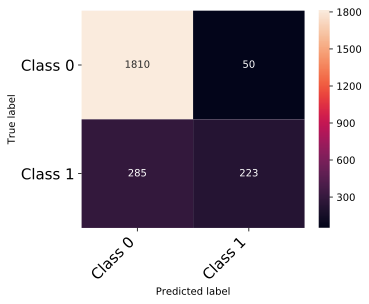

In [53]:
cm = print_confusion_matrix(confusion_matrix(y_train, svm_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Linear SVC

IS THE CODE CORRECT?

HOW TO ADD TO ROC/AUC/SCORING?

In [ ]:
# Run CV with 5 folds (Linear SVC)

C = np.logspace(-3, 1, 25)
# gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C)
# param_grid = dict(C=C, gamma=gammas)


# LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

svc1 = LinearSVC()
svc_grid = GridSearchCV(svc1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svc_grid.fit(x_norm_train, y_train)

In [ ]:
svc_grid.best_estimator_

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y_train, svc_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Naive Bayes Model

In [54]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train, y_train)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


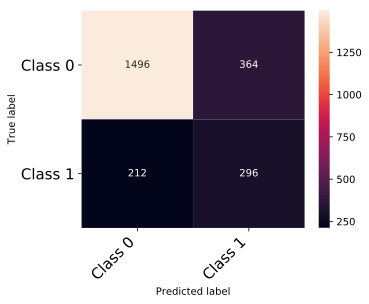

In [55]:
cm = print_confusion_matrix(confusion_matrix(y_train, gnb_best.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Decision Tree Classifier GridSearchCV

CORRECT CODE BELOW?

ADD TO ROC-AUC & SCORING

In [ ]:
# Run CV with 5 folds (Decision Tree Classifier)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

dectree = DecisionTreeClassifier()
dectree_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
dectree_grid.fit(x_norm_train, y_train)

In [ ]:
dectree_grid.best_estimator_

In [ ]:
cm = print_confusion_matrix(confusion_matrix(y_train, dectree_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Random Forest GridSearchCV

In [30]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [58]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 200}

In [38]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
# rf_model with best params

rf_model = RandomForestClassifier(bootstrap = True, max_depth = None, max_features = 'sqrt', min_samples_leaf = 10, 
                                  min_samples_split = 10, n_estimators = 200)


In [60]:
# final model to pickle to use in Flask app

model = rf_model.fit(X_train, np.array(y_train))

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [61]:
# pickling final model for Flask app

filename = 'credit_card_default_model.sav'
pickle.dump(model, open(filename, 'wb'))



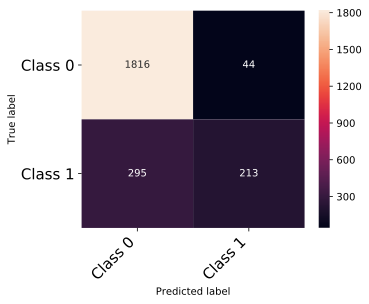

In [42]:
cm = print_confusion_matrix(confusion_matrix(y_train, rf_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [65]:
# Random Forest Feature Importances

rf2 = RandomForestRegressor(n_estimators=200, max_depth = None)
rf2.fit(X_train, y_train)
rf2.feature_importances_

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([0.07263714, 0.06399901, 0.04667479, 0.0475653 , 0.0404544 ,
       0.05064551, 0.05177444, 0.04841766, 0.05779433, 0.05199262,
       0.04721696, 0.05067579, 0.06521747, 0.06268143, 0.01920371,
       0.07997947, 0.08162229, 0.00888826, 0.00857157, 0.01038424,
       0.01216103, 0.00987551, 0.00220695, 0.00936011])

In [80]:
# zip each feature importance weight with my columns

rf_feature_importances = pd.DataFrame(zip(list(rf2.feature_importances_), X_train.columns), columns=['feature_importances', 'feature_names'])
rf_feature_importances.sort_values(by='feature_importances', ascending=False)

,feature_importances,feature_names
16,0.081622,pay_2
15,0.079979,pay_0
0,0.072637,age
12,0.065217,pay_amt_6
1,0.063999,bill_amt_1
13,0.062681,limit_balance
8,0.057794,pay_amt_2
9,0.051993,pay_amt_3
6,0.051774,bill_amt_6
11,0.050676,pay_amt_5


### Gradient Boosting Classifier GridSearchCV

In [ ]:
parameter_grid={
    "loss":["deviance"],
    "learning_rate": [0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.01, 0.1, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[10,20],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[ 1.0],
    "n_estimators":[125]
    }
gbc_grid = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)
gbc_grid.fit(x_norm_train, y_train)

### XGBoost

In [ ]:
# run later and do feature importances

### Scoring the models

#### ROC_AUC

In [56]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.7213
Best ROC_AUC for logit: 0.7212
Best ROC_AUC for svm: 0.7279
Best ROC_AUC for rf: 0.7436


#### F1

In [ ]:
# score on F1

# from sklearn.metrics import f1_score

# y_true = 
# y_pred = 

# f1_score(y_true, y_pred, average='macro')  

# f1_score(y_true, y_pred, average='micro')  

# f1_score(y_true, y_pred, average='weighted')  

# f1_score(y_true, y_pred, average=None)


#### Best parameters

In [57]:
print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for knn:  {'n_neighbors': 51}
Best Patams for logit:  {'C': 0.26560877829466867, 'penalty': 'l1'}
Best Params for svm:  {'C': 4.6415888336127775, 'gamma': 0.042169650342858224}
Best Params for rf:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


#### NOTE QUESTIONS IN BELOW COMMENTED CODE

In [ ]:
# ROC for all the models

# ARE THE X/Y VARIABLES THE CORRECT ONES TO USE HERE?
# How does the ensembe work?

# How to add new models above into this? E.g., Linear SVC, 

model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best, 
              rf_grid.best_estimator_,
              'ensemble']
model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.10
        w2 = 0.80
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_test)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_test)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_test)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()